# Carhart Four-Factor Model

---

## 1. Introduction

The **Carhart Four-Factor Model** (1997) extends the Fama-French Three-Factor Model by adding a **momentum factor (WML — Winners Minus Losers)**. It is one of the most widely used asset pricing models in academic finance and is expressed as:

$$R_i - R_f = \alpha_i + \beta_1 \cdot (R_m - R_f) + \beta_2 \cdot SMB + \beta_3 \cdot HML + \beta_4 \cdot WML + \epsilon_i$$

Where:

| Symbol | Description |
| --- | --- |
| $R_i - R_f$ | **Excess return** of the portfolio/asset over the risk-free rate |
| $R_m - R_f$ | **Market premium** — excess market return over the risk-free rate |
| $SMB$ | **Small Minus Big** — size premium (small-cap outperformance) |
| $HML$ | **High Minus Low** — value premium (high B/M outperformance) |
| $WML$ | **Winners Minus Losers** — momentum premium (past winners outperformance) |
| $\alpha_i$ | **Jensen's alpha** — abnormal return not explained by the four factors |
| $\epsilon_i$ | **Error term** — idiosyncratic risk |

### Key Insights

- **$\alpha \neq 0$** suggests the portfolio generates returns unexplained by systematic risk factors (either superior skill or model mis-specification).
- A **positive SMB beta** indicates the portfolio tilts toward small-cap stocks.
- A **positive HML beta** indicates a value tilt.
- A **positive WML beta** indicates momentum exposure.
- The model is used for **performance attribution**, **risk decomposition**, and **fund evaluation**.

---

## 2. Our Analysis: Fama-French 4-Factor Decomposition of Nifty 50 Returns (India)

### Objective

We will decompose the **daily returns of the Nifty 50 index** using the Carhart Four-Factor Model with **India-specific factors**.

### Data Sources

`nifty50_price.csv` : You can obtain from yahoo finance (yfinance library)<br>
`india_fourfactor.csv` : You can obtain for India from (https://faculty.iima.ac.in/iffm/Indian-Fama-French-Momentum/)





| File | Contents | Key Columns |
| --- | --- | --- |
| `nifty50_price.csv` | Daily Nifty 50 closing prices | `Date`, `Close` |
| `india_fourfactor.csv` | Daily India four-factor data | `Date`, `SMB`, `HML`, `WML`, `MF` (market factor), `RF` (risk-free rate) |

### Methodology

1. **Compute Nifty 50 daily returns** from closing prices: $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} \times 100$
2. **Compute excess returns**: $R_{excess,t} = R_{Nifty50,t} - RF_t$
3. **Merge** the Nifty 50 excess returns with the four-factor data on the `Date` column.
4. **Full-sample OLS regression**: Regress Nifty 50 excess returns on `MF`, `SMB`, `HML`, and `WML`.
5. **1-Year rolling OLS regression**: Estimate the model on a rolling 252-trading-day window to capture time-varying factor exposures.
6. **Visualise** the rolling betas and alpha to understand how factor exposures evolve over time.

---

## 3. Setup & Data Loading

In [2]:
# ── Imports ──────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings('ignore')

# ── Plot style ──────────────────────────────────────────
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (14, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'font.family': 'sans-serif',
})

print('Libraries loaded successfully.')

Libraries loaded successfully.


In [3]:
# ── Load Nifty 50 Prices ─────────────────────────────────
nifty = pd.read_csv('nifty50_price.csv', skiprows=[1])   # row 1 has "Ticker" metadata
nifty['Date'] = pd.to_datetime(nifty['Date'])
nifty = nifty.sort_values('Date').reset_index(drop=True)

# Compute daily percentage returns
nifty['Nifty_Return'] = nifty['Close'].pct_change() * 100
nifty = nifty.dropna(subset=['Nifty_Return'])

print(f'Nifty 50 data: {nifty.shape[0]:,} trading days  |  {nifty["Date"].min().date()} → {nifty["Date"].max().date()}')
nifty[['Date', 'Close', 'Nifty_Return']].head()

Nifty 50 data: 4,486 trading days  |  2007-09-18 → 2025-12-31


,Date,Close,Nifty_Return
1,2007-09-18,4546.200195,1.146926
2,2007-09-19,4732.350098,4.094626
3,2007-09-20,4747.549805,0.321187
4,2007-09-21,4837.549805,1.895715
5,2007-09-24,4932.200195,1.956577


In [4]:
# ── Load Four-Factor Data ────────────────────────────────
factors = pd.read_csv('india_fourfactor.csv')
factors['Date'] = pd.to_datetime(factors['Date'])

# Convert factor columns to numeric, coerce errors to NaN
for col in ['SMB', 'HML', 'WML', 'MF', 'RF']:
    factors[col] = pd.to_numeric(factors[col], errors='coerce')

factors = factors.dropna(subset=['SMB', 'HML', 'WML', 'MF', 'RF']).sort_values('Date').reset_index(drop=True)

print(f'Factor data  : {factors.shape[0]:,} trading days  |  {factors["Date"].min().date()} → {factors["Date"].max().date()}')
factors.head()

Factor data  : 8,002 trading days  |  1993-10-04 → 2025-12-31


,Date,SMB,HML,WML,MF,RF
0,1993-10-04,0.457111,0.359427,-0.652693,-0.938504,0.022014
1,1993-10-05,0.036392,0.817520,-0.844160,-0.294867,0.022014
2,1993-10-06,0.048067,-1.720945,0.156209,-0.327369,0.022014
3,1993-10-07,-0.333093,0.047752,-0.010776,0.378873,0.022014
4,1993-10-08,1.030353,2.119714,0.411035,0.856365,0.022014


---

## 4. Merging & Preparing the Regression Dataset

We perform an **inner merge** on `Date` so that only dates present in both datasets are retained. Then we compute the **excess return** of Nifty 50 by subtracting the risk-free rate (`RF`).

In [5]:
# ── Merge on Date ────────────────────────────────────────
df = pd.merge(
    nifty[['Date', 'Close', 'Nifty_Return']],
    factors[['Date', 'SMB', 'HML', 'WML', 'MF', 'RF']],
    on='Date',
    how='inner'
).sort_values('Date').reset_index(drop=True)

# Compute excess return
df['Excess_Return'] = df['Nifty_Return'] - df['RF']

print(f'Merged dataset: {df.shape[0]:,} observations  |  {df["Date"].min().date()} → {df["Date"].max().date()}')
print(f'\nDescriptive Statistics (% daily):')
df[['Excess_Return', 'MF', 'SMB', 'HML', 'WML']].describe().round(4)

Merged dataset: 4,486 observations  |  2007-09-18 → 2025-12-31

Descriptive Statistics (% daily):


,Excess_Return,MF,SMB,HML,WML
count,4486.0000,4486.0000,4486.0000,4486.0000,4486.0000
mean,0.0228,0.0231,-0.0067,0.0290,0.0484
std,1.3051,1.1986,0.8040,0.8744,0.9262
min,-13.0192,-10.7993,-5.4078,-6.0338,-7.1882
25%,-0.5450,-0.5010,-0.4388,-0.4489,-0.3941
50%,0.0388,0.0927,0.0470,0.0291,0.0815
75%,0.6277,0.6187,0.4560,0.4921,0.5369
max,17.7176,15.8334,5.1731,5.5972,7.9931


---

## 5. Full-Sample OLS Regression

We now estimate the Carhart Four-Factor Model using **Ordinary Least Squares (OLS)** on the entire sample:

$$R_{Nifty50,t} - R_{f,t} = \alpha + \beta_{MF} \cdot MF_t + \beta_{SMB} \cdot SMB_t + \beta_{HML} \cdot HML_t + \beta_{WML} \cdot WML_t + \epsilon_t$$

In [6]:
# ── Full-Sample OLS ──────────────────────────────────────
y = df['Excess_Return']
X = df[['MF', 'SMB', 'HML', 'WML']]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit(cov_type='HC1')  # White's heteroskedasticity-robust standard errors
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     4467.
Date:                Mon, 23 Feb 2026   Prob (F-statistic):               0.00
Time:                        21:36:33   Log-Likelihood:                -2107.4
No. Observations:                4486   AIC:                             4225.
Df Residuals:                    4481   BIC:                             4257.
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.006      0.663      0.5

---

## 6. Interpreting the Full-Sample Results

### How to read the regression output:

| Metric | What it tells us |
| --- | --- |
| **R-squared** | Proportion of Nifty 50 excess return variance explained by the four factors. Higher = better model fit. |
| **const (α)** | Jensen's Alpha — the daily abnormal return after controlling for the four systematic factors. A statistically significant positive α implies that the Nifty 50 generated excess risk-adjusted returns. |
| **MF (β₁)** | Market factor loading. Expected to be close to **1.0** since Nifty 50 *is* a market index. |
| **SMB (β₂)** | Size factor loading. A **negative** coefficient means Nifty 50 tilts toward large-cap (expected for a large-cap index). |
| **HML (β₃)** | Value factor loading. **Positive** = value tilt; **Negative** = growth tilt. |
| **WML (β₄)** | Momentum factor loading. Shows if the index has momentum exposure. |
| **P-value** | If p < 0.05, the coefficient is statistically significant at the 5% level. |

### What to expect:
- **MF ≈ 1.0**: Nifty 50 is a broad market index, so the market factor should dominate.
- **SMB < 0**: Large-cap bias of the index.
- **α ≈ 0**: If the model is well-specified, the index's returns should be largely explained by the factors.

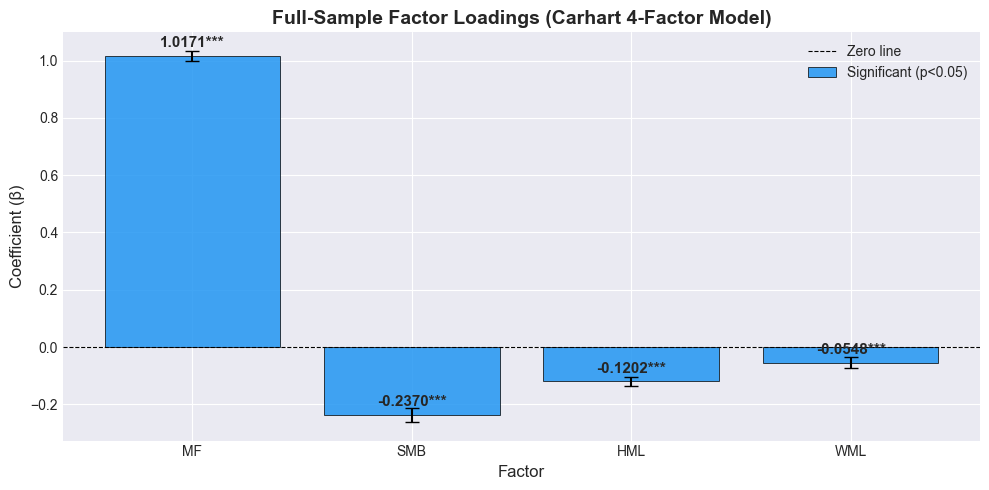


Jensen's Alpha (daily) = 0.003848%
Jensen's Alpha (annualised ≈ ×252) = 0.9697%
Alpha p-value = 0.507448


In [7]:
# ── Visualise Coefficient Magnitudes ─────────────────────
coefs = model.params.drop('const')
errors = model.bse.drop('const')
pvals = model.pvalues.drop('const')

colors = ['#2196F3' if p < 0.05 else '#BDBDBD' for p in pvals]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(coefs.index, coefs.values, yerr=1.96 * errors.values,
              color=colors, edgecolor='black', linewidth=0.6,
              capsize=5, alpha=0.85)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title('Full-Sample Factor Loadings (Carhart 4-Factor Model)', fontsize=14, fontweight='bold')
ax.set_ylabel('Coefficient (β)')
ax.set_xlabel('Factor')

# Annotate values
for bar, val, pv in zip(bars, coefs.values, pvals.values):
    sig = '***' if pv < 0.01 else '**' if pv < 0.05 else '*' if pv < 0.1 else ''
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.4f}{sig}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.legend(['Zero line', 'Significant (p<0.05)', 'Not significant'],
          loc='upper right', framealpha=0.9)
plt.tight_layout()
plt.show()

print(f"\nJensen's Alpha (daily) = {model.params['const']:.6f}%")
print(f"Jensen's Alpha (annualised ≈ ×252) = {model.params['const'] * 252:.4f}%")
print(f"Alpha p-value = {model.pvalues['const']:.6f}")

---

## 7. Residual Diagnostics

Checking whether OLS assumptions hold: **normality** and **autocorrelation** of residuals.

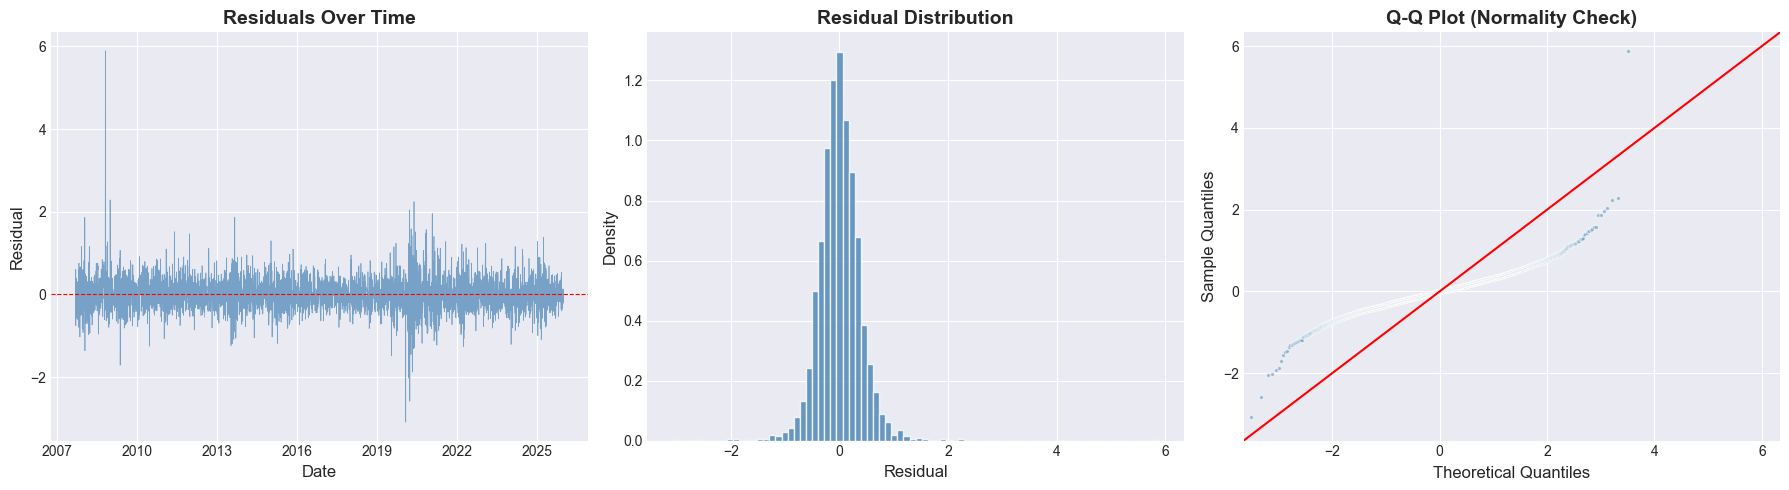

Durbin-Watson Statistic: 1.9480  (≈2.0 → no autocorrelation)


In [8]:
# ── Residual Analysis ────────────────────────────────────
residuals = model.resid

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1) Residuals over time
axes[0].plot(df['Date'], residuals, color='steelblue', linewidth=0.5, alpha=0.7)
axes[0].axhline(0, color='red', linewidth=0.8, linestyle='--')
axes[0].set_title('Residuals Over Time', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Residual')
axes[0].xaxis.set_major_locator(mdates.YearLocator(3))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# 2) Histogram
axes[1].hist(residuals, bins=80, color='steelblue', edgecolor='white', density=True, alpha=0.8)
axes[1].set_title('Residual Distribution', fontweight='bold')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Density')

# 3) QQ Plot
sm.qqplot(residuals, line='45', ax=axes[2], markerfacecolor='steelblue',
          markeredgecolor='white', markersize=3, alpha=0.5)
axes[2].set_title('Q-Q Plot (Normality Check)', fontweight='bold')

plt.tight_layout()
plt.show()

# Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw:.4f}  (≈2.0 → no autocorrelation)')

### Residual Diagnostics — Interpretation

- **Residuals Over Time**: Should appear roughly random (no systematic pattern). Clusters of high residuals indicate **volatility clustering** (common in financial data).
- **Histogram**: Financial residuals often exhibit **fat tails** (leptokurtosis) — more extreme values than a normal distribution.
- **Q-Q Plot**: Departures from the 45° line in the tails confirm **non-normality**, which is expected. This is why we use **robust standard errors (HC1)**.
- **Durbin-Watson ≈ 2.0**: Indicates minimal serial autocorrelation in residuals.

---

## 8. One-Year Rolling Regression

Financial markets are inherently **non-stationary** — factor exposures shift over time due to:
- Changes in index composition (periodic Nifty 50 rebalancing)
- Macro-economic regime shifts (QE, rate cycles, COVID, geopolitical events)
- Evolving sectoral weights within the index

A **rolling 252-day (≈ 1 trading year) regression** captures these time-varying dynamics:

$$\text{For each window } [t-252, t]: \quad R_{excess,\tau} = \alpha_t + \beta_{MF,t} \cdot MF_\tau + \beta_{SMB,t} \cdot SMB_\tau + \beta_{HML,t} \cdot HML_\tau + \beta_{WML,t} \cdot WML_\tau + \epsilon_\tau$$

In [14]:
# ── Rolling OLS (252-day window) ─────────────────────────
WINDOW = 252

endog = df.set_index('Date')['Excess_Return']
exog = sm.add_constant(df.set_index('Date')[['MF', 'SMB', 'HML', 'WML']])

rolling_model = RollingOLS(endog, exog, window=WINDOW)
rolling_results = rolling_model.fit()

# Extract rolling parameters
rolling_params = rolling_results.params.dropna()
rolling_params.columns = ['Alpha', 'MF_beta', 'SMB_beta', 'HML_beta', 'WML_beta']

print(f'Rolling regression windows: {len(rolling_params):,}')
print(f'Period covered: {rolling_params.index.min().date()} → {rolling_params.index.max().date()}')
rolling_params.describe().round(4)

Rolling regression windows: 4,235
Period covered: 2008-09-22 → 2025-12-31


,Alpha,MF_beta,SMB_beta,HML_beta,WML_beta
count,4235.0000,4235.0000,4235.0000,4235.0000,4235.0000
mean,0.0044,1.0231,-0.2049,-0.0898,-0.0235
std,0.0227,0.0954,0.0891,0.0639,0.0665
min,-0.0699,0.8276,-0.3978,-0.2712,-0.2421
25%,-0.0093,0.9638,-0.2560,-0.1278,-0.0546
50%,0.0050,1.0173,-0.2079,-0.0887,-0.0121
75%,0.0218,1.0989,-0.1684,-0.0507,0.0144
max,0.0518,1.2094,0.0566,0.0992,0.1319


---

## 9. Rolling Factor Betas — Visualisation

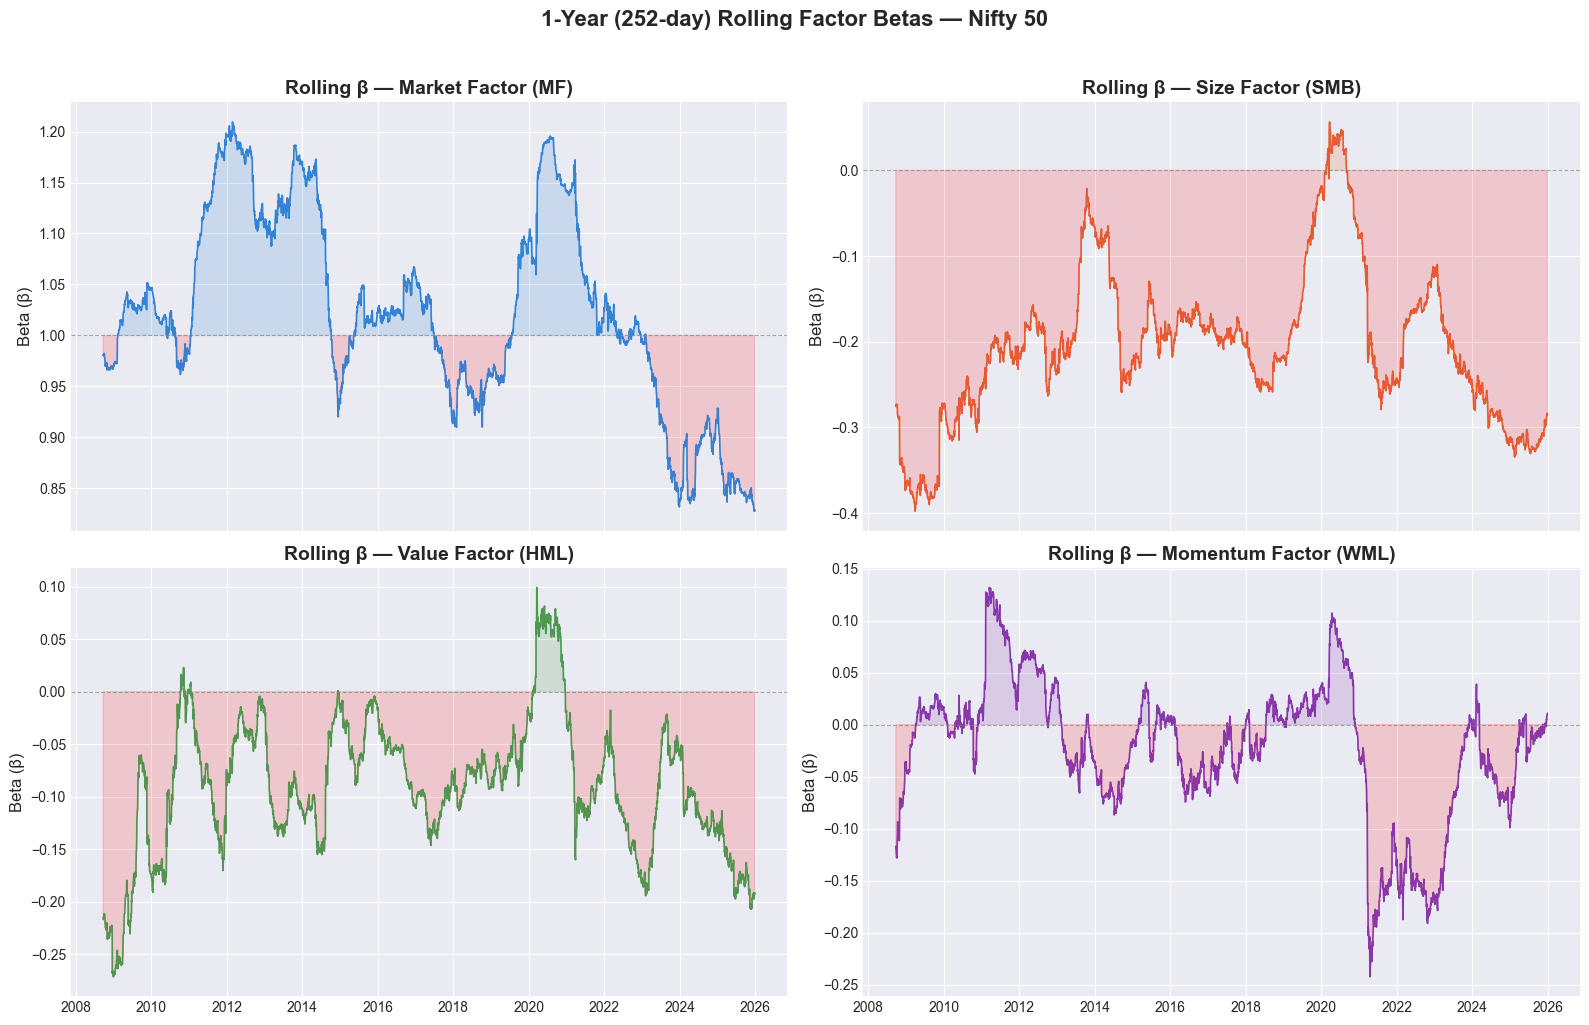

In [15]:
# ── Plot Rolling Betas ───────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True)

factor_info = [
    ('MF_beta', 'Market Factor (MF)', '#1976D2', 1.0),
    ('SMB_beta', 'Size Factor (SMB)', '#E64A19', 0.0),
    ('HML_beta', 'Value Factor (HML)', '#388E3C', 0.0),
    ('WML_beta', 'Momentum Factor (WML)', '#7B1FA2', 0.0),
]

for ax, (col, title, color, ref) in zip(axes.flatten(), factor_info):
    ax.plot(rolling_params.index, rolling_params[col], color=color, linewidth=1.2, alpha=0.85)
    ax.axhline(ref, color='grey', linewidth=0.8, linestyle='--', alpha=0.7)
    ax.fill_between(rolling_params.index, rolling_params[col], ref,
                    where=rolling_params[col] > ref, alpha=0.15, color=color)
    ax.fill_between(rolling_params.index, rolling_params[col], ref,
                    where=rolling_params[col] < ref, alpha=0.15, color='red')
    ax.set_title(f'Rolling β — {title}', fontweight='bold')
    ax.set_ylabel('Beta (β)')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('1-Year (252-day) Rolling Factor Betas — Nifty 50', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Reading the Rolling Beta Charts

| Factor | What to look for |
| --- | --- |
| **MF (Market)** | Should stay close to **1.0** (Nifty 50 largely tracks the market). Deviations indicate periods where the index diverged from the broad Indian market portfolio. |
| **SMB (Size)** | Generally **≤ 0** for a large-cap index. If it turns positive, small-cap style characteristics are "leaking" into the index (e.g., during broad rallies). |
| **HML (Value)** | Shifts between positive and negative reveal whether the index‟s constituent stocks are behaving more like value or growth at different times. |
| **WML (Momentum)** | Positive → the index is momentum-aligned (trending market). Negative → reversals are dominating. |

---

## 10. Rolling Alpha (Jensen's Alpha)

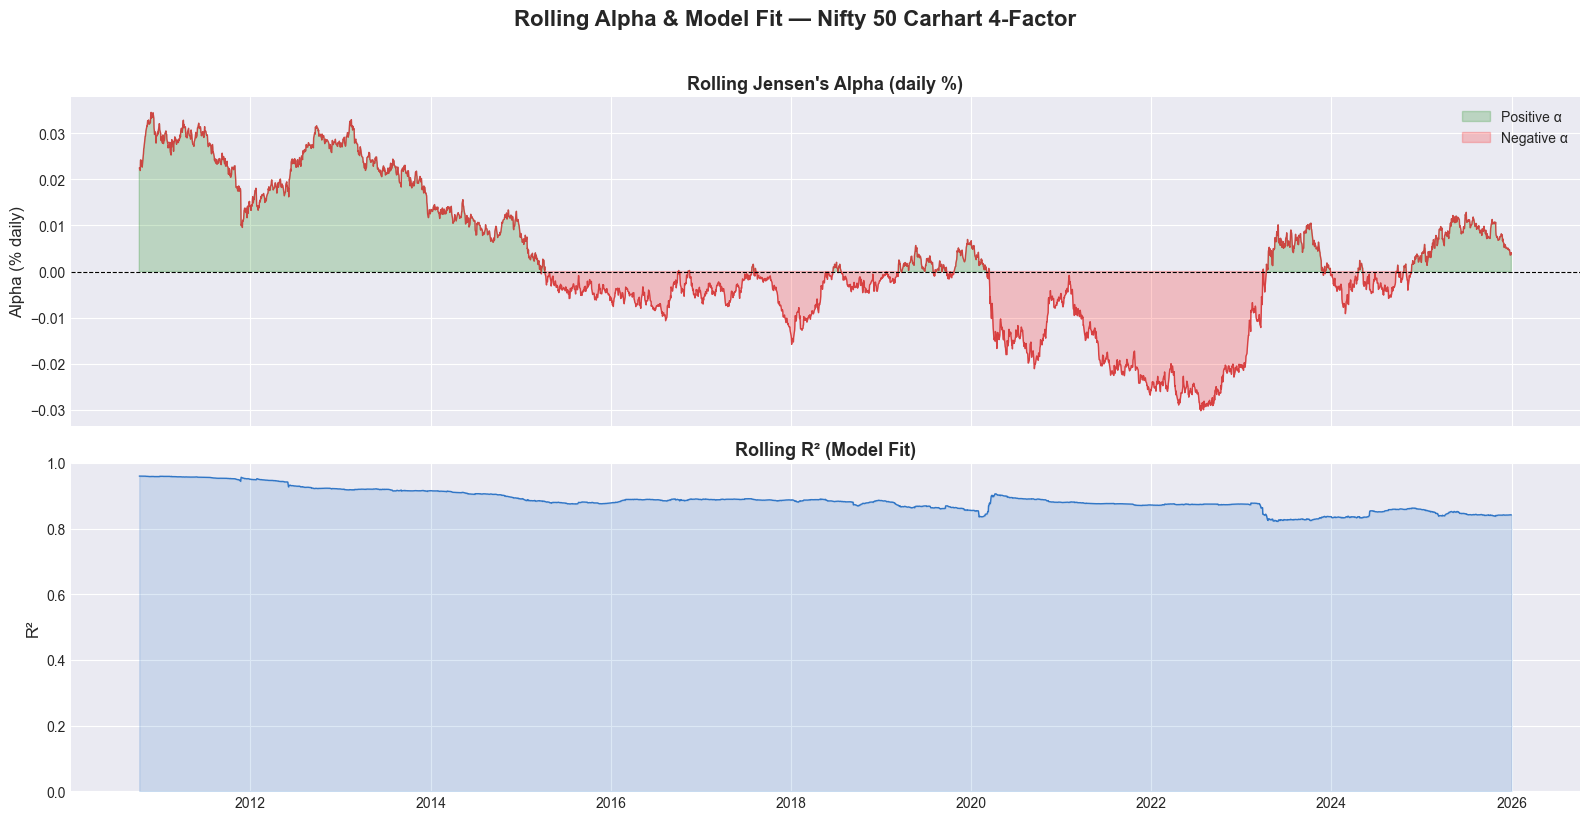

Average Rolling R² = 0.8867
Average Rolling Alpha (daily) = 0.001909%
Average Rolling Alpha (annualised) = 0.4810%


In [11]:
# ── Rolling Alpha and R-squared ──────────────────────────
rolling_rsq = rolling_results.rsquared.dropna()

fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Alpha
axes[0].plot(rolling_params.index, rolling_params['Alpha'], color='#D32F2F', linewidth=1.0, alpha=0.85)
axes[0].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[0].fill_between(rolling_params.index, rolling_params['Alpha'], 0,
                     where=rolling_params['Alpha'] > 0, alpha=0.2, color='green', label='Positive α')
axes[0].fill_between(rolling_params.index, rolling_params['Alpha'], 0,
                     where=rolling_params['Alpha'] < 0, alpha=0.2, color='red', label='Negative α')
axes[0].set_title('Rolling Jensen\'s Alpha (daily %)', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Alpha (% daily)')
axes[0].legend(loc='upper right')

# R-squared
axes[1].plot(rolling_rsq.index, rolling_rsq.values, color='#1565C0', linewidth=1.0, alpha=0.85)
axes[1].fill_between(rolling_rsq.index, rolling_rsq.values, 0, alpha=0.15, color='#1565C0')
axes[1].set_title('Rolling R² (Model Fit)', fontweight='bold', fontsize=13)
axes[1].set_ylabel('R²')
axes[1].set_ylim(0, 1)
axes[1].xaxis.set_major_locator(mdates.YearLocator(2))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.suptitle('Rolling Alpha & Model Fit — Nifty 50 Carhart 4-Factor', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'Average Rolling R² = {rolling_rsq.mean():.4f}')
print(f'Average Rolling Alpha (daily) = {rolling_params["Alpha"].mean():.6f}%')
print(f'Average Rolling Alpha (annualised) = {rolling_params["Alpha"].mean() * 252:.4f}%')

### Interpreting Rolling Alpha & R²

- **Rolling Alpha**: Measures the **daily abnormal return** not explained by the four factors, estimated on a trailing 1-year window.
  - Persistently positive alpha would suggest the Nifty 50 offers returns *above* what its factor exposures predict.
  - In practice, alpha fluctuates around zero — consistent with market efficiency.
  
- **Rolling R²**: Shows how well the four factors explain Nifty 50 returns at each point in time.
  - **R² close to 1.0** → the model captures most of the return variation.
  - **Dips in R²** often coincide with crisis periods (GFC 2008, COVID 2020) where idiosyncratic / event risk dominates.

---

## 11. Combined Rolling Betas

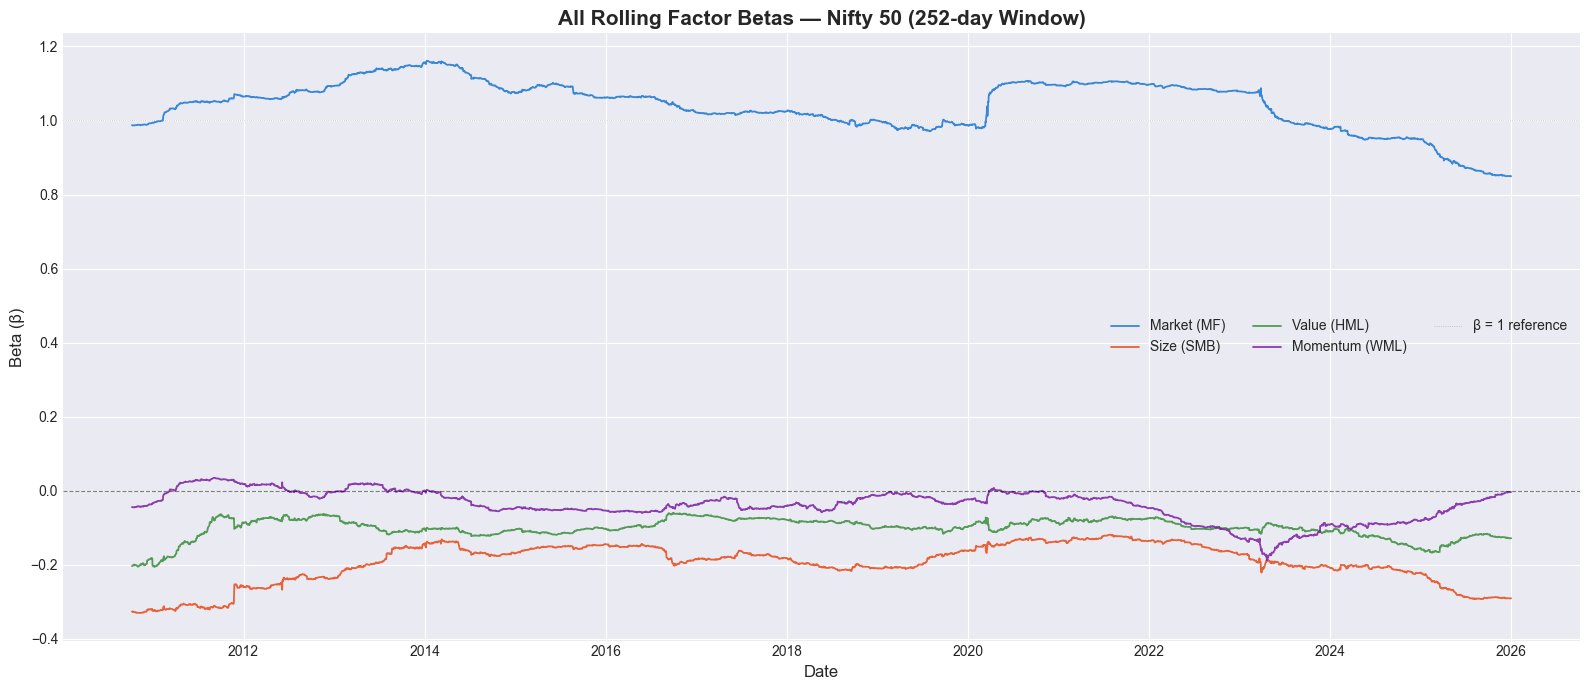

In [12]:
# ── All betas on one chart ───────────────────────────────
fig, ax = plt.subplots(figsize=(16, 7))

beta_colors = {'MF_beta': '#1976D2', 'SMB_beta': '#E64A19', 'HML_beta': '#388E3C', 'WML_beta': '#7B1FA2'}
beta_labels = {'MF_beta': 'Market (MF)', 'SMB_beta': 'Size (SMB)', 'HML_beta': 'Value (HML)', 'WML_beta': 'Momentum (WML)'}

for col in ['MF_beta', 'SMB_beta', 'HML_beta', 'WML_beta']:
    ax.plot(rolling_params.index, rolling_params[col],
            label=beta_labels[col], color=beta_colors[col], linewidth=1.3, alpha=0.85)

ax.axhline(0, color='black', linewidth=0.8, linestyle='--', alpha=0.5)
ax.axhline(1.0, color='grey', linewidth=0.6, linestyle=':', alpha=0.5, label='β = 1 reference')
ax.set_title('All Rolling Factor Betas — Nifty 50 (252-day Window)', fontsize=15, fontweight='bold')
ax.set_ylabel('Beta (β)')
ax.set_xlabel('Date')
ax.legend(loc='best', framealpha=0.9, ncol=3)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.tight_layout()
plt.show()

---

## 12. Summary & Conclusions

### Full-Sample Results
- The Carhart 4-Factor Model provides a strong fit for Nifty 50 returns, as reflected by the R-squared value.
- The **Market Factor (MF)** dominates — unsurprising since the Nifty 50 *is* a market index.
- Factor loadings on **SMB, HML, WML** reveal the index's style tilts (size, value, momentum).
- **Robust standard errors** are used since financial returns exhibit heteroskedasticity.

### Rolling Regression Insights
- Factor betas are **time-varying**, confirming that a static model over-simplifies reality.
- The **Market beta** stays close to 1 but fluctuates — especially during crises.
- **SMB, HML, WML betas** oscillate around zero, reflecting changing style exposures.
- Rolling R² indicates periods where the model explains more or less of the Nifty 50's variation.

### Practical Implications
1. **For researchers**: Rolling estimates reveal structural breaks in factor exposures — useful for regime-detection studies.
2. **For portfolio managers**: Understanding time-varying factor tilts of a benchmark helps in constructing factor-hedged portfolios.
3. **For fund evaluation**: A fund's alpha should be measured relative to these time-varying exposures, not static betas.

---

*Notebook created for Fama-French 4-Factor research analysis on Indian equity markets.*